# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [2]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2019,5,1,0,0,0),
                                    '$lt': datetime.datetime(2020,8,1,0,0,0)},
            'retweeted_id': None
            })
        ))

In [3]:
time_sample_df = time_sample_df.drop(['partei'], axis=1)
time_sample_df.sort_values('created_at_datetime').tail(2)

_id                      created_at  \
149602  5f27dda7b971ae79d7bcd7f6  Fri Jul 31 22:54:58 +0000 2020   
114154  5f27d8451877913ad89bcb85  Fri Jul 31 22:55:15 +0000 2020   

                         id  \
149602  1289333763063734272   
114154  1289333833238581248   

                                                                                                                                                                                                                                                                                                            full_text  \
149602  @Gegen_die_AfD @Volksverpetzer Ja!!                                                                                                                                                                                                                                                                             
114154  Retweet #ausGründen - @dfg_public versucht, es einem digitalen Mob recht zu machen und löscht das sehr gute Statement von Dieter #Nuhr zu #fuerdaswissen, weil er sich laut einiger Shitstormtrooper „anti-wissenschaftlich“ äußere. Das ist falsch, die Löschung auch. #Wissenschaft https://t.co/UgHR2bf1rq   

        is_quote_status  retweet_count lang created_at_datetime     user_id  \
149602  False            0              und 2020-07-31 22:54:58  1425265488   
114154  True             23             de  2020-07-31 22:55:15  149299258    

                   user_name user_screen_name             user_location  \
149602  Renate Künast         RenateKuenast    Berlin                     
114154  Alexander Lambsdorff  Lambsdorff       Bonn, Berlin und Brüssel   

                                                                                                                                                  user_description  \
149602  Feministin, Foodie, Gärtnerin. Anwältin, Sozialarbeiterin, MdB. Verbraucherministerin.a.D , Kämpfe für das Recht + RechtaufNahrung #darumGrün                
114154  Stv. Vorsitzender, #FDP im #Bundestag; Vice President #ALDE Party, Fan von #effzeh, #Jazz, #Bonn und #Tatort. RT kein/no endorsement. Alle Tweets von mir.   

        user_followers_count  user_friends_count  \
149602  61664                 1770                 
114154  17659                 627                  

                       user_created_at user_party  
149602  Mon May 13 11:24:44 +0000 2013  Gruene     
114154  Fri May 28 23:15:13 +0000 2010  FDP

#### Detailbetrachtung Datensatz

In [36]:
# Betrachte Tweets von Johannes Kahrs genauer
import re
kahrs = time_sample_df.loc[(time_sample_df['user_screen_name'] == 'kahrs')]
#print(len(kahrs))
kahrs['full_text'][kahrs['full_text'].str.match(r'.*fröhlicher gruss.*(?i)')==True].count()

#len(time_sample_df[time_sample_df['user_screen_name'] == 'Karl_Lauterbach']['full_text'])
#time_sample_df[time_sample_df['user_screen_name'] == 'EskenSaskia']['full_text']

806

In [45]:
set(sample_df.loc[(sample_df['user_party'] == 'Linke')
                        & (sample_df['week'] == '19-w52')
                     ]['date'])

{datetime.date(2019, 12, 29),
 datetime.date(2019, 12, 30),
 datetime.date(2019, 12, 31)}

In [31]:
%%html
<style>
table {float:left}
</style>

## Übersicht der Tweets pro Partei 

Gibt es Namen die keiner Partei zugeordnet werden konnten?
* AfdBystron - Satire Account
* EspendillerM - Name geändert wegen Dr. Titel

*Müssen bei nächstem Datenbank- Update angepasst werden*


##### Beispiel für die Übersicht für Tweets im Zeitraum 01.01.2019 - 10.05.2020

|Partei  |  Tweets |      |mdp gesamt|mdp Twitter|Anteil Twitter user|Tweets pro user
|--------|---------|      |----------|-----------|----------|---------------
|AFD     |  12959  |      |89        |26         |29,21     |498
|FDP     |  47759  |      |80        |69         |86,25     |692
|Gruene  |  39910  |      |67        |57         |85,07     |700
|Linke   |  36422  |      |69        |49         |71,01     |743
|SPD     |  44520  |      |152       |102        |67,11     |436
|Union   |  39979  |      |246       |122        |49,59     |328


##### Entferne Tweets ohne Parteizuordnung

Nach der Überarbeitung der Namenslisten (manuelle Suche auf Twitter), wurden die folgenden "Namen" aus Listen entfernt, für die jedoch Tweets in der Datenbank stehen.

* AfdBystron       -- aus mongodb entfernen
* cducsubt         -- aus mongodb entfernen
* fdpbt            -- aus mongodb entfernen
* kahrs            -- Collection "parteizuordnung" um diesen Politiker + Partei ergänzen
* BabettesChefin   -- aus mongodb entfernen ("twittert nicht mehr. „Nicht meine Politik-Kommunikation!“)
* ruppert_stefan   -- Collection "parteizuordnung" um diesen Politiker + Partei ergänzen
* PetrBystronAfD   -- Muss in normale Liste mit aufgenommen werden! (== aktueller Account)
* EspendillerM     -- Collection "parteizuordnung" um diesen Politiker + Partei ergänzen

In [3]:
# no_party = time_sample_df[time_sample_df.user_party.isnull()].user_screen_name
# for i in set(no_party):
#     print(i)

sample_df = time_sample_df[time_sample_df.user_party.isnull()== False]
len(sample_df['user_screen_name'])

240148

##### Felder zur Betrachtung auf Tagesebene und Wochenebene 

In [6]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%U')

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Erstellen eines Dictionary für Parteizugehörikgeit

In [6]:
partei_dic = {}
parteien = ['Union', 'SPD', 'Gruene', 'Linke', 'FDP', 'AFD']

for partei in parteien:
    partei_dic['tweets_'+ partei] = sample_df[sample_df['user_party'] == partei]  

# Explorative Daten Analyse (EDA) - nach Partei gegliedert
## 1.) Allgemeine Übersicht
##### Eingrenzung der relevanten Spalten

In [7]:
mdp_tweets = sample_df[['created_at_datetime', 'date' , 'week', 'month', 'user_screen_name','user_party', 'full_text']]
#mdp_tweets.tail()

##### Eingrenzung der relevanten Zeilen

In [17]:
mdp_tweets = mdp_tweets.loc[(mdp_tweets['date'] < datetime.date(2020,8,1)) 
                            & (mdp_tweets['date'] >= datetime.date(2019,5,1))]

##### Pivotierung
* Wie viel hat welche Partei an welchem Tag getwittert?
* Wie viel haben die Mitglieder einer Partei in best. Zeiraum getwittert?
* Wie viel hat ein best Mitglied an welchem Tag getwittert?

In [18]:
import numpy as np
mdp_partei = mdp_tweets[['user_party', 'date', 'week', 'user_screen_name', 'full_text']]
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv['full_text'].tail()
# partei_Piv = partei_piv['full_text']
# partei_Piv.groupby('week').sum()

user_party  AFD  FDP  Gruene  Linke   SPD  Union
week                                            
20-w26      459  976  849     794    1103  793  
20-w27      499  583  607     590    563   599  
20-w28      482  680  536     744    536   594  
20-w29      513  596  422     464    548   552  
20-w30      344  733  348     430    531   492

In [19]:
partei_piv_dic = {}

for partei in parteien:
    partei_mdp = mdp_tweets[mdp_tweets['user_party'] == partei]
    patei_names = partei_mdp[['user_screen_name', 'date']]
    partei_piv_dic[partei] = pd.pivot_table(patei_names, index = 'user_screen_name', aggfunc = np.count_nonzero )
    
partei_piv_dic['FDP'].head(3)

date
user_screen_name      
AKulitz           56  
BraFDP            661 
BrittaDassler     29

In [20]:
name_piv_dic = {}
    
for partei in parteien:
    partei_mdp = mdp_tweets[mdp_tweets['user_party'] == partei]
    partei_names = partei_mdp[['user_screen_name', 'date']]
    for name in set(partei_names['user_screen_name']):
        name_piv = pd.pivot_table(partei_names[partei_names['user_screen_name'] == name], index = 'date', aggfunc = np.count_nonzero)
        name_piv_dic[name] = name_piv
# name_piv_dic['StBrandner'].head(5)

### Erstelle Übersichtstabelle 

In [30]:
mdp_gesamt = [246, 152, 67, 69, 80, 89] # https://www.bundestag.de/parlament/plenum/sitzverteilung_19wp

tweets_piv = pd.pivot_table(mdp_partei, index = 'user_party', aggfunc = np.count_nonzero )['full_text']
Tweets = []
for partei in parteien:
    Tweets.append(tweets_piv[partei])

mdp_Twitter = []
for partei in parteien:
    mdp_Twitter.append(len(partei_piv_dic[partei]))

summary_df = pd.DataFrame({'user_party':parteien, 'Tweets': Tweets, 'mdp_gesamt': mdp_gesamt, 'mdp_Twitter': mdp_Twitter})
summary_df['Anteil_Twitter_user'] = round(summary_df['mdp_Twitter']/summary_df['mdp_gesamt']*100, 2)
summary_df['Tweets_pro_user'] = round(summary_df['Tweets']/summary_df['mdp_Twitter'])
summary_df.index = summary_df['user_party']
summary_df = summary_df.drop(columns = 'user_party')
summary_df


Tweets  mdp_gesamt  mdp_Twitter  Anteil_Twitter_user  \
user_party                                                         
Union       39621   246         131          53.25                 
SPD         47256   152         110          72.37                 
Gruene      39349   67          60           89.55                 
Linke       40191   69          57           82.61                 
FDP         46856   80          75           93.75                 
AFD         26875   89          71           79.78                 

            Tweets_pro_user  
user_party                   
Union       302.0            
SPD         430.0            
Gruene      656.0            
Linke       705.0            
FDP         625.0            
AFD         379.0

In [41]:
# #name_piv_dic['StBrandner'][name_piv_dic['StBrandner'].index == datetime.date(2020,2,6)]
# for tweet in mdp_partei.index:
#     if((mdp_partei['user_screen_name'][tweet] == 'StBrandner') and mdp_partei['date'][tweet] == datetime.date(2020,5,3)):
#         #print(mdp_partei['date'][tweet])
#         print(mdp_partei['full_text'][tweet])


# Grafen

### Welcher Abgeordnete tweetet am meisten?

In [23]:
partei_piv_dic = {}

for partei in parteien:
    partei_mdp = mdp_tweets[mdp_tweets['user_party'] == partei]
    patei_names = partei_mdp[['user_screen_name', 'date']]
    partei_piv_dic[partei] = pd.pivot_table(patei_names, index = 'user_screen_name', aggfunc = np.count_nonzero )
    
# partei_piv_dic['FDP'].sort_values(by ='date', ascending=False).head(3)

In [49]:
partei_piv_df = []
for party in parteien:
    df = partei_piv_dic[party].sort_values(by ='date', ascending=False).head(5)
    
    df = df.rename(columns={"date":"count"})
    df['user_screen_name'] = df.index
    df = df.iloc[0:].reset_index(drop=True)
    df['partei'] = party
    partei_piv_df.append(df)
    
result = pd.concat(partei_piv_df)
result = result.iloc[0:].reset_index(drop=True)
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
colors = ['black','red','green', 'purple', 'orange', 'blue']

result.index = result['user_screen_name']
result = result[['count', 'partei']]

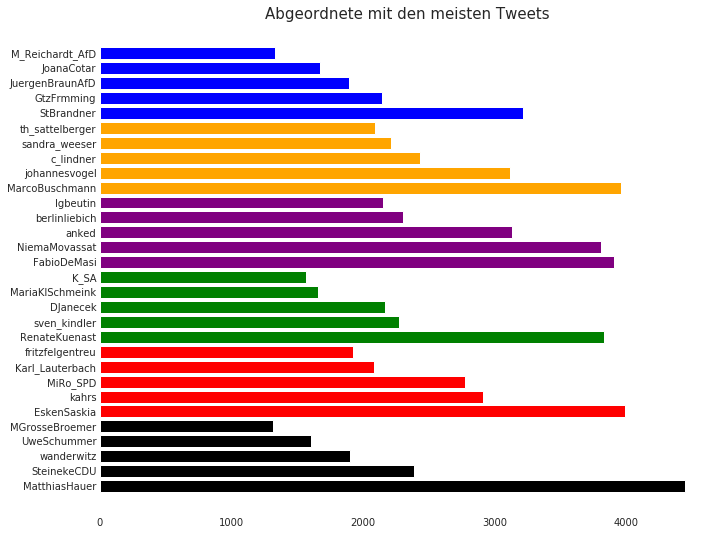

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (11, 9))
sns.set_style("white")
ax = fig.add_subplot(111)
ax.set_title('Abgeordnete mit den meisten Tweets', fontsize = 15)


for user in result.index:
    if result['partei'][user] == 'AFD':
        ax = plt.barh(user, result['count'][user], color = 'blue')
    elif result['partei'][user] == 'FDP':
        ax = plt.barh(user, result['count'][user], color = 'orange')
    elif result['partei'][user] == 'Linke':
        ax = plt.barh(user, result['count'][user], color = 'purple')        
    elif result['partei'][user] == 'Gruene':
        ax = plt.barh(user, result['count'][user], color = 'green')        
    elif result['partei'][user] == 'Union':
        ax = plt.barh(user, result['count'][user], color = 'black')               
    else:
        ax = plt.barh(user, result['count'][user], color = 'red')


### Grafen zur Menge von Tweets über die Zeit

In [9]:
import numpy as np
mdp_tweets = sample_df[['created_at_datetime', 'date' , 'week', 'month', 'user_screen_name','user_party', 'full_text']]
mdp_partei = mdp_tweets[['user_party', 'date', 'week', 'month', 'user_screen_name', 'full_text']]
# mdp_partei = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2020,1,1)) 
#                             & (mdp_partei['date'] <= datetime.date(2020,5,31))]
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['date'], aggfunc = np.count_nonzero)
partei_piv['full_text'].tail()

user_party   AFD    FDP  Gruene  Linke    SPD  Union
date                                                
2020-07-27  52.0  99.0   58.0    70.0   74.0   61.0 
2020-07-28  57.0  107.0  42.0    72.0   42.0   66.0 
2020-07-29  71.0  120.0  77.0    92.0   116.0  102.0
2020-07-30  57.0  176.0  59.0    55.0   92.0   95.0 
2020-07-31  63.0  91.0   61.0    63.0   99.0   75.0

Text(0.5, 1.0, 'Monatliche Übersicht 2017 - Juli 2020')

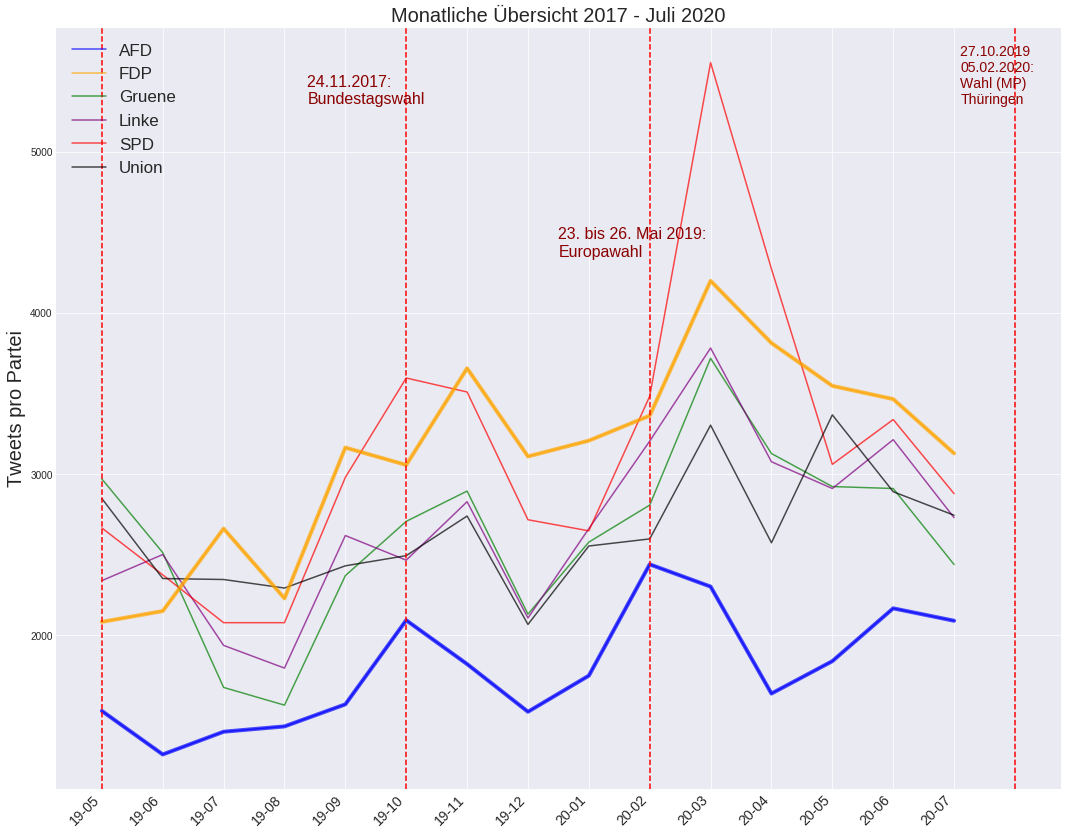

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import pandas as pd
import numpy as np

# mdp_tweets = sample_df[['created_at_datetime', 'date' , 'week', 'month', 'user_screen_name','user_party', 'full_text']]
mdp_partei = mdp_tweets[['user_party', 'date', 'week', 'month', 'user_screen_name', 'full_text']]
mdp_partei = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2017,1,1)) 
                            & (mdp_partei['date'] <= datetime.date(2020,8,1))]
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)



#plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (18, 14))
ax = fig.add_subplot(111)

num=0
for column in partei_piv['full_text']:
    ax.plot(partei_piv.index, partei_piv['full_text'][column], color = my_palette[num], alpha=0.7, label = column)
    num+=1
    
ax.plot(partei_piv.index, partei_piv['full_text']['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
ax.plot(partei_piv.index, partei_piv['full_text']['FDP'], marker='', color='orange', linewidth=4, alpha=0.7)

ax.axvline('17-09', ls='--', color='r')
ax.text(0.25, 0.9, '24.11.2017: \nBundestagswahl', color='darkred', fontsize=16, transform=ax.transAxes)
    
ax.axvline('19-05', ls='--', color='r')
ax.text(0.5, 0.7, '23. bis 26. Mai 2019: \nEuropawahl', color='darkred', fontsize=16, transform=ax.transAxes)

ax.axvline('19-10', ls='--', color='r')
ax.axvline('20-02', ls='--', color='r')
ax.text(0.9, 0.9, '27.10.2019 \n05.02.2020:\nWahl (MP) \nThüringen', color='darkred', fontsize=14, transform=ax.transAxes)
 
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
plt.legend(loc = 2, ncol = 1, fontsize = 17)

x_tags = plt.xticks(partei_piv.index, fontsize = 14, rotation = 45, ha = "right")

ax.set_title('Monatliche Übersicht 2017 - Juli 2020', fontsize = 20)




Text(0.5, 1.0, 'Wöchtentliche Übersicht März - 6. Mai 2020')

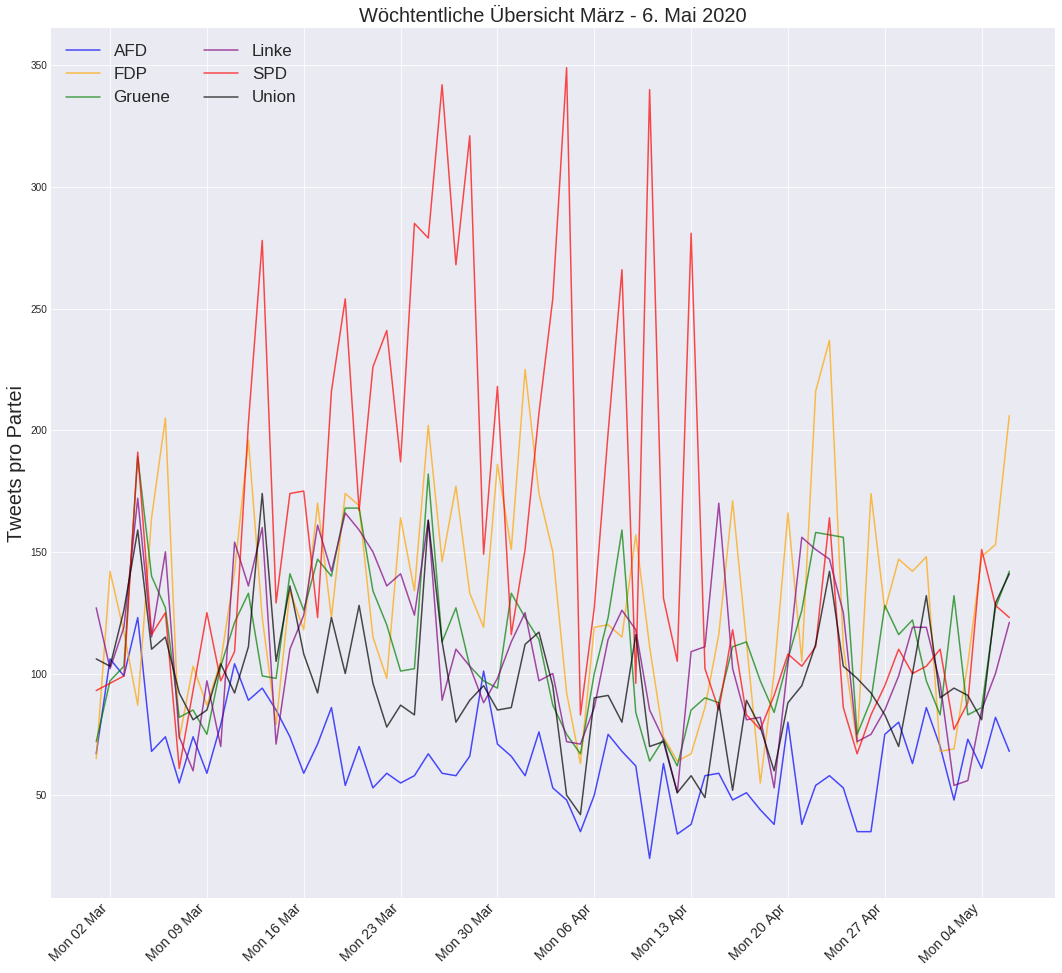

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import pandas as pd
import numpy as np

mdp_partei = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2020,3,1)) 
                            & (mdp_partei['date'] <= datetime.date(2020,5,6))]
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['date'], aggfunc = np.count_nonzero)



#plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (18, 16))
ax = fig.add_subplot(111)

num=0
for column in partei_piv['full_text']:
    ax.plot(partei_piv.index, partei_piv['full_text'][column], color = my_palette[num], alpha=0.7, label = column)
    num+=1
    
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
plt.legend(loc = 2, ncol = 2, fontsize = 17)

x_tags = plt.xticks(partei_piv.index, fontsize = 14, rotation = 45, ha = "right")

# x-tags
weekdays = mdates.WeekdayLocator(byweekday=(MO), interval=1)
weekdays_fmt = mdates.DateFormatter('%a %d %b')


ax.xaxis.set_major_locator(weekdays)
ax.xaxis.set_major_formatter(weekdays_fmt)
ax.set_title('Wöchtentliche Übersicht März - 6. Mai 2020', fontsize = 20)




In [82]:
pd.set_option('display.max_rows', None)
mdp_tweets.loc[(mdp_tweets.date <= datetime.date(2017,11,30)) 
               & (mdp_tweets.date >= datetime.date(2017,11,1))
               & (mdp_tweets.user_party == 'SPD')
               # & (mdp_tweets.user_screen_name == 'StBrandner')
              ]

created_at_datetime        date    week  month user_screen_name  \
40036  2017-11-30 20:47:18  2017-11-30  17-w48  17-11  NielsAnnen        
40037  2017-11-19 22:58:36  2017-11-19  17-w47  17-11  NielsAnnen        
40038  2017-11-19 13:12:30  2017-11-19  17-w47  17-11  NielsAnnen        
40039  2017-11-14 17:23:09  2017-11-14  17-w46  17-11  NielsAnnen        
40155  2017-11-28 09:40:48  2017-11-28  17-w48  17-11  soerenbartol      
40188  2017-11-21 10:04:43  2017-11-21  17-w47  17-11  Lothar_Binding    
40313  2017-11-26 10:26:44  2017-11-26  17-w48  17-11  baerbelbas        
40394  2017-11-27 17:59:42  2017-11-27  17-w48  17-11  BrunnerGanzOhr    
40446  2017-11-27 11:54:45  2017-11-27  17-w48  17-11  larscastellucci   
40447  2017-11-20 11:36:04  2017-11-20  17-w47  17-11  larscastellucci   
40448  2017-11-02 17:49:55  2017-11-02  17-w44  17-11  larscastellucci   
40500  2017-11-29 17:30:34  2017-11-29  17-w48  17-11  DeRidder_MdB      
40501  2017-11-18 10:32:47  2017-11-18  17-w46  17-11  DeRidder_MdB      
41475  2017-11-20 17:19:40  2017-11-20  17-w47  17-11  fritzfelgentreu   
41476  2017-11-19 14:33:53  2017-11-19  17-w47  17-11  fritzfelgentreu   
41477  2017-11-16 19:07:30  2017-11-16  17-w46  17-11  fritzfelgentreu   
41478  2017-11-14 17:46:00  2017-11-14  17-w46  17-11  fritzfelgentreu   
41479  2017-11-13 22:02:14  2017-11-13  17-w46  17-11  fritzfelgentreu   
41480  2017-11-10 11:50:30  2017-11-10  17-w45  17-11  fritzfelgentreu   
41481  2017-11-08 13:56:07  2017-11-08  17-w45  17-11  fritzfelgentreu   
41482  2017-11-06 19:11:05  2017-11-06  17-w45  17-11  fritzfelgentreu   
41483  2017-11-06 18:32:29  2017-11-06  17-w45  17-11  fritzfelgentreu   
41484  2017-11-06 13:20:25  2017-11-06  17-w45  17-11  fritzfelgentreu   
41485  2017-11-05 18:22:51  2017-11-05  17-w45  17-11  fritzfelgentreu   
41486  2017-11-03 07:50:36  2017-11-03  17-w44  17-11  fritzfelgentreu   
41589  2017-11-01 12:28:22  2017-11-01  17-w44  17-11  A_Gloeckner       
41828  2017-11-19 17:43:10  2017-11-19  17-w47  17-11  Timon_Gremmels    
42484  2017-11-28 21:06:36  2017-11-28  17-w48  17-11  fritzfelgentreu   
42485  2017-11-25 09:10:32  2017-11-25  17-w47  17-11  fritzfelgentreu   
42486  2017-11-24 17:16:30  2017-11-24  17-w47  17-11  fritzfelgentreu   
42487  2017-11-21 22:15:47  2017-11-21  17-w47  17-11  fritzfelgentreu   
42488  2017-11-21 08:52:19  2017-11-21  17-w47  17-11  fritzfelgentreu   
42489  2017-11-20 21:50:25  2017-11-20  17-w47  17-11  fritzfelgentreu   
42512  2017-11-17 19:33:17  2017-11-17  17-w46  17-11  UliFreese         
42794  2017-11-27 17:46:58  2017-11-27  17-w48  17-11  MarcusHeld_SPD    
42820  2017-11-24 10:21:16  2017-11-24  17-w47  17-11  HellmichMdB       
42821  2017-11-16 20:50:09  2017-11-16  17-w46  17-11  HellmichMdB       
43073  2017-11-30 05:53:32  2017-11-30  17-w48  17-11  KerstinGriese     
43074  2017-11-29 22:41:41  2017-11-29  17-w48  17-11  KerstinGriese     
43075  2017-11-24 18:20:57  2017-11-24  17-w47  17-11  KerstinGriese     
43076  2017-11-24 18:10:00  2017-11-24  17-w47  17-11  KerstinGriese     
43077  2017-11-23 22:05:51  2017-11-23  17-w47  17-11  KerstinGriese     
43078  2017-11-20 18:34:32  2017-11-20  17-w47  17-11  KerstinGriese     
43079  2017-11-20 18:25:08  2017-11-20  17-w47  17-11  KerstinGriese     
43080  2017-11-20 18:21:15  2017-11-20  17-w47  17-11  KerstinGriese     
43081  2017-11-20 17:55:51  2017-11-20  17-w47  17-11  KerstinGriese     
43082  2017-11-19 09:48:04  2017-11-19  17-w47  17-11  KerstinGriese     
43127  2017-11-16 19:08:40  2017-11-16  17-w46  17-11  KerstinGriese     
43128  2017-11-16 14:49:54  2017-11-16  17-w46  17-11  KerstinGriese     
43129  2017-11-15 19:51:54  2017-11-15  17-w46  17-11  KerstinGriese     
43130  2017-11-15 15:53:11  2017-11-15  17-w46  17-11  KerstinGriese     
43131  2017-11-15 13:54:13  2017-11-15  17-w46  17-11  KerstinGriese     
43132  2017-11-13 16:19:37  2017-11-13  17-w46  17-11  KerstinGriese     
43133  2017

In [83]:
mdp_tweets.columns

Index(['created_at_datetime', 'date', 'week', 'month', 'user_screen_name',
       'user_party', 'full_text'],
      dtype='object')

# Wordclouds

In [8]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
# sample_df['full_text_processed'].head(200)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/anaconda3/bin/ipython:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

##### Stopwords

In [9]:
from stop_words import get_stop_words
stop_words_one = get_stop_words('de')

import stopwordsiso as stopwords
stop_words_two = list(stopwords.stopwords(["de"])) 

for word in stop_words_two:
    if word in stop_words_one:
        continue
    else:
        print(word)
        stop_words_one.append(word)


mehr_sw = ['cducsubt','GrueneBundestag','the', 'and', 'for', 'tb', 'cducsubt', 'spdbt', 
           'fdpbt', 'sdpde', 'gruenebundestag', 'linksfraktion', 'dielinke', 'bundestag', 'afdimbundestag'
          'csu_bt', 'spdde']

for word in mehr_sw:
    stop_words_one.append(word)
    

wurde
mussten
elf
r
überhaupt
zurück
f
x
d
außer
sechster
ausser
bereits
jemandem
neben
davor
t
zwölf
dritte
j
ersten
wirklich
gemacht
satt
anderr
wart
zuerst
viele
darunter
mochte
nie
gewollt
p
werdet
zehn
statt
rechte
oft
vierte
grosse
o
ag
gute
dritten
zusammen
hast
fünfte
später
kommen
unsem
dürfen
gemusst
mehr
dasein
gekannt
gar
ganze
habt
mann
vielleicht
übrigens
vier
großes
wissen
darfst
jemand
ei
ab
allgemeinen
darüber
einander
deshalb
gern
sa
sowie
unses
zugleich
k
entweder
außerdem
heute
z.b
kannst
nahm
solang
gekonnt
erstes
eigen
danach
sache
siebente
sechste
tritt
unse
sollten
sagt
bald
dermaßen
dank
viertes
dermassen
niemandem
vielem
großer
ganzen
weniges
mochten
gehen
tage
eigenen
soweit
startseite
magst
zehnter
konnten
gemocht
währenddem
durchaus
wenigstens
zeit
durften
neuen
eigenes
hattet
kam
q
l
hätten
mag
neunte
sollen
allein
ach
schon
weiteren
ei,
neue
leicht
ehrlich
deren
willst
d.h
mögt
sei
darauf
e
achte
grosses
eben
drittes
sollt
morgen
trotzdem
damals
kleine
zw

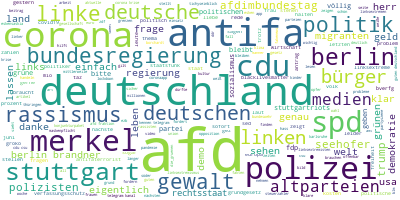

In [15]:
from wordcloud import WordCloud
mdp_partei = sample_df.loc[(sample_df['date'] >= datetime.date(2020,5,25)) 
                           & (sample_df['date'] <= datetime.date(2020,7,1))
                           & (sample_df['user_party'] == 'AFD')
                          ]

# Join the different processed titles together.
long_string = ','.join(mdp_partei['full_text_processed'])
clean_text = [word for word in long_string.split() if word not in stop_words_one]
clean_string = ','.join(clean_text)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words_one, min_word_length=3)
# Generate a word cloud
wordcloud.generate(clean_string)
# Visualize the word cloud
wordcloud.to_image()

#### Wordcloud zu bestimmtem Zeitunkt

### Wöchentliche Wordcloud - AFD

Text(0.5, 1.01, 'FDP_Tweets')

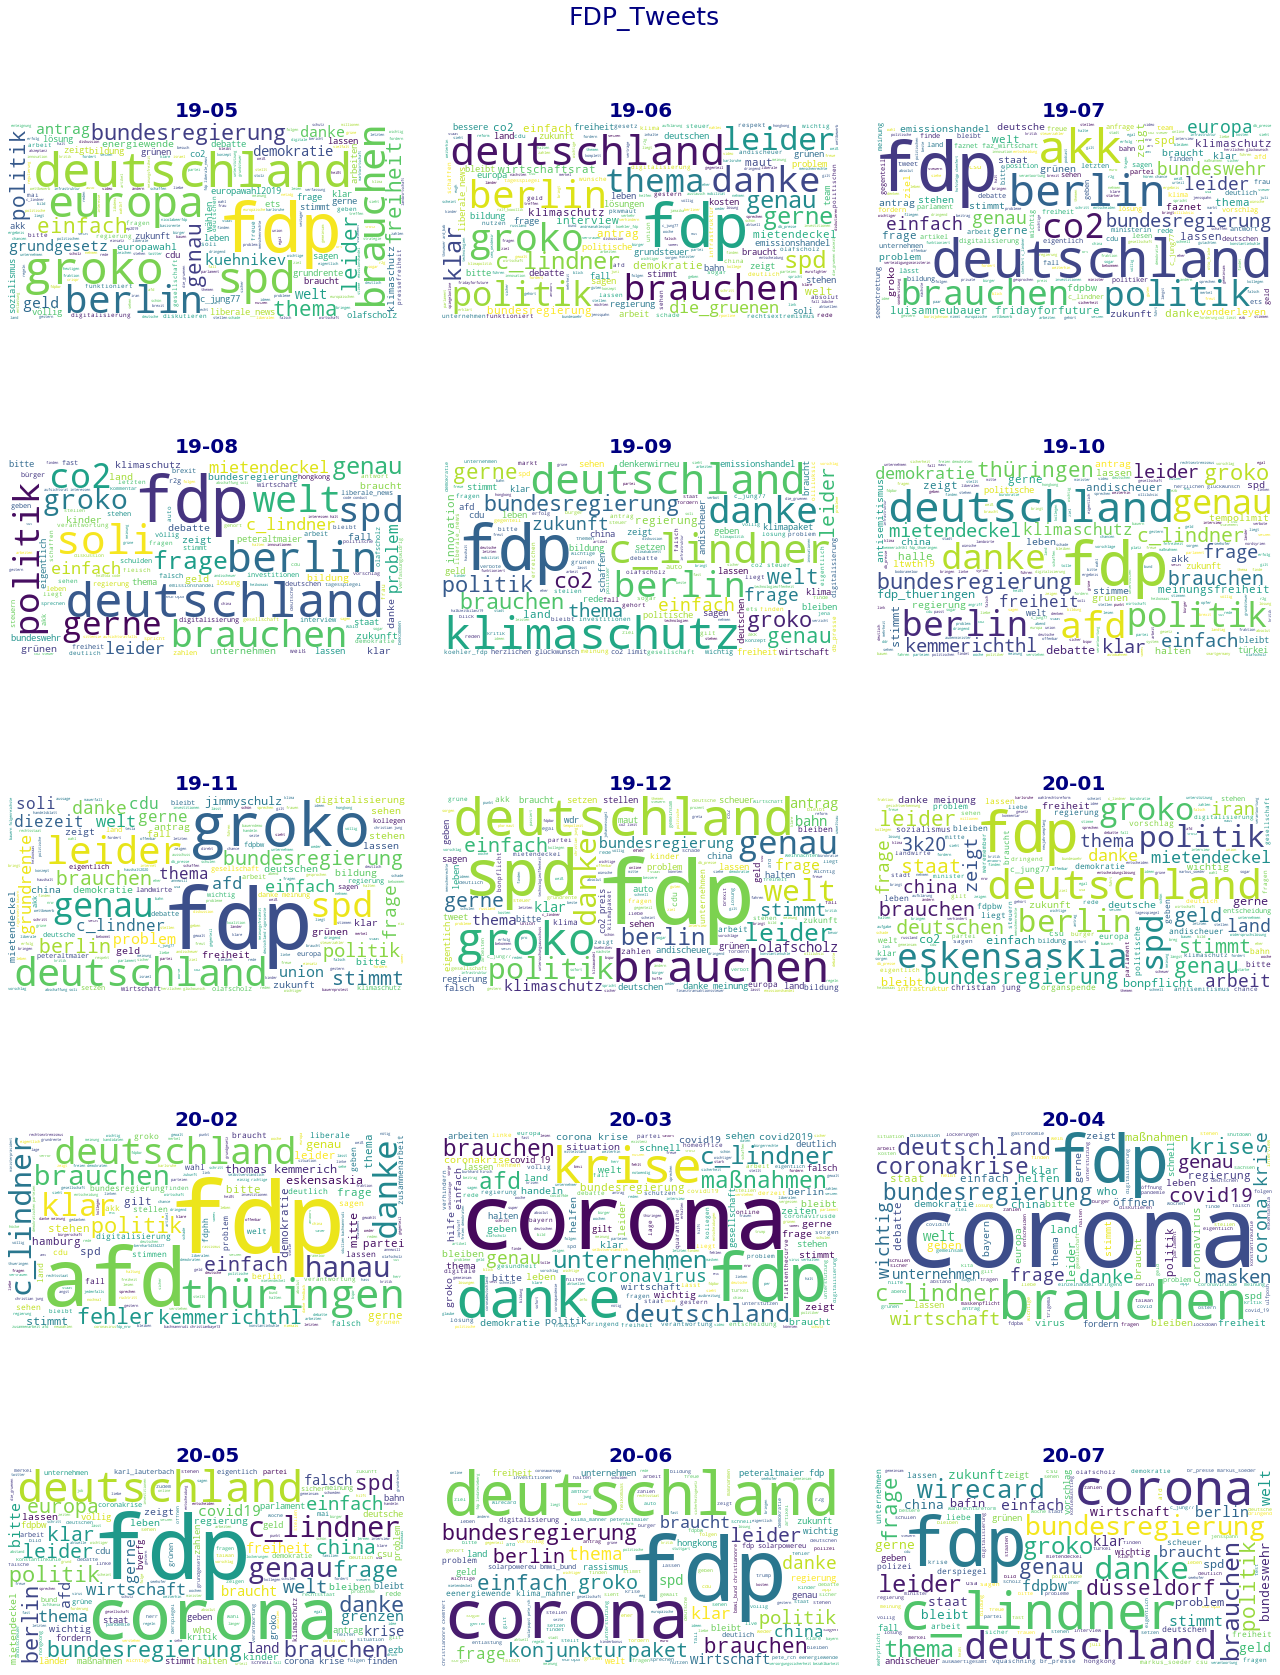

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud

party = 'FDP'

sample_df_partei = sample_df[sample_df.user_party == party]

sample_df_month = list(set(sample_df_partei['month']))
sample_df_month.sort()

date_dic_partei = {}
   
for month in sample_df_month:
    date_dic_partei[month] = sample_df_partei[sample_df_partei['month'] == month]

    
def FktWordCloud(clean_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words_one, min_word_length=3)
    wordcloud.generate(clean_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (18, 50))

for month, n in zip(date_dic_partei, range(1,len(date_dic_partei.keys())+1)):
    title = month

    ax = fig.add_subplot(15,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    long_string = ','.join(date_dic_partei[month]['full_text_processed'])
    clean_text = [word for word in long_string.split() if word not in stop_words_one]
    clean_string = ','.join(clean_text)

    wordcloud = FktWordCloud(clean_string)
    ax.imshow(wordcloud)
    ax.axis('off')

fig.suptitle(party + '_Tweets', fontsize=25, color='navy', y=1.01)

#### Wordcloud Gegenüberstellung von Parteien

In [41]:
save_sw = stop_words_one

extra_sw = ['corona', 'brauchen', 'bundesregierung', 'deutschland', 'berlin', 'die_gruenen']
for word in extra_sw:
    stop_words_one.append(word)

/usr/local/anaconda3/bin/ipython:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5, 1.05, 'Europawahl 2019 - Wordcloud für den Zeitraum 20.-31-05')

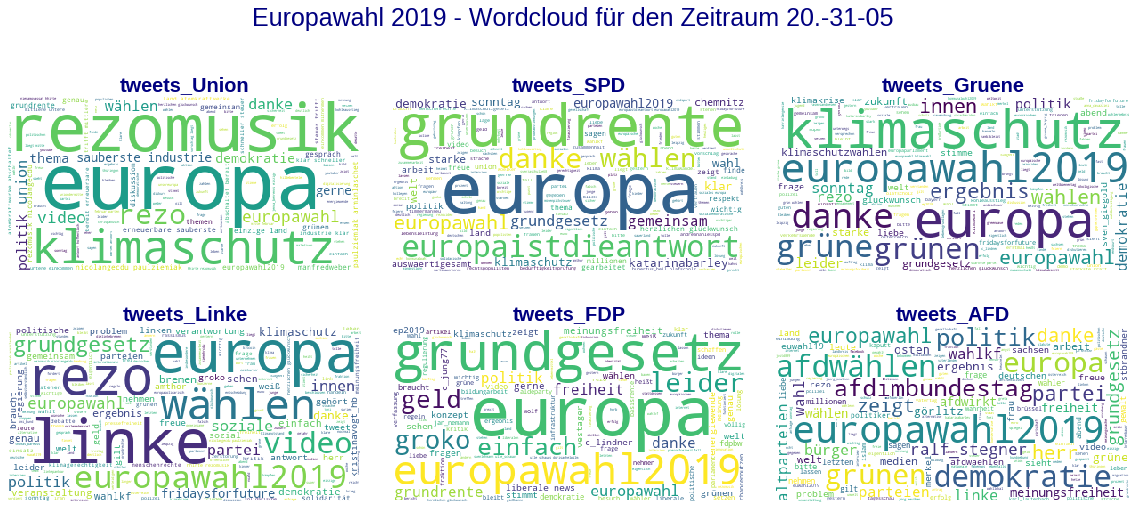

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud


sample_df_date = sample_df.loc[(sample_df['date'] <= datetime.date(2019,5,31)) 
                               & (sample_df['date'] >= datetime.date(2019,5,20))]
# sample_df_date = sample_df

partei_dic_date = {}
for partei in parteien:
    partei_dic_date['tweets_'+ partei] = sample_df_date[sample_df['user_party'] == partei]  


def FktWordCloud(clen_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words_one, min_word_length=4)
    wordcloud.generate(clean_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (16, 16))
#fig.subplots_adjust(top=0.8)

for partei, n in zip(partei_dic_date, range(1,7)):
    title = str(partei)
    
    ax = fig.add_subplot(5,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_partei=partei_dic_date[partei]
    long_string = ','.join(sample_df_partei['full_text_processed'])
    clean_text = [word for word in long_string.split() if word not in stop_words_one]
    clean_string = ','.join(clean_text)
    wordcloud = FktWordCloud(clean_string)
    ax.imshow(wordcloud)
    ax.axis('off')
fig.suptitle('Europawahl 2019 - Wordcloud für den Zeitraum 20.-31-05', fontsize=25, color='navy', y=1.05)